[VPIN] bucket_volume = 18,574,025.12
[RESULT] fills=14 closed=5


,ts,equity,cash,n_positions
0,2024-03-12 15:23:00.700000+00:00,100.083510,100.083510,0
1,2024-03-12 16:44:00.300000+00:00,99.758748,99.758748,0
2,2024-03-12 16:54:00.300000+00:00,99.292743,99.292743,0
3,2024-03-12 17:15:05.600000+00:00,99.375672,99.375672,0
4,2024-03-12 17:30:03.400000+00:00,99.452423,99.452423,0



=== METRICS ===
             Final Equity: 99.45242295676039
       Total PnL (equity): -0.5475770432396132
         Total Return (%): -0.5475770432396132
                   Sharpe: -336.18799560391767
                  MDD (%): -0.7907666830267601
                     RMDD: -0.6924634724666098
                 Mean Ret: -0.12621735062927825
                  Std Ret: 0.22616134300155155
             Turnover (%): 997.5572675267238
        Total Fees (cash): 0.39411034084825924
     Gross PnL (sum EXIT): -0.026122809300873823
       Net PnL (sum EXIT): -0.42023315014913304
         Gross Return (%): -0.026122809300873823
           Net Return (%): -0.420233150149133


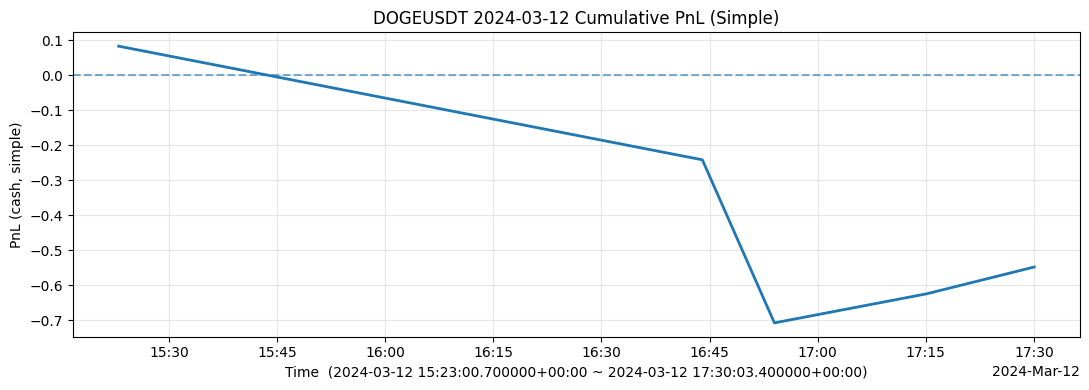

In [ ]:
from hft_backtest_engine.data_loader import DataLoader
from hft_backtest_engine.feature_store import FeatureStore
from hft_backtest_engine.execution import ExecutionEngine
from hft_backtest_engine.backtest_engine import BacktestEngine
from hft_backtest_engine.strategy_base import Strategy, StrategyConfig
from hft_backtest_engine.run_backtest import estimate_vpin_bucket_volume
import pandas as pd

# ===================== 
# USER PARAMETERS
# =====================
DATA_ROOT = r"D:/fpa_data"
SYMBOL = "DOGEUSDT"
DAY = "2024-03-12"

INITIAL_CAPITAL = 100.0

# 🔧 핵심 튜닝 포인트
TARGET_VPIN_BUCKETS = 500     # 👈 여기 바꾸면서 실험
VPIN_GATE_THRESHOLD = 0.65

# =====================
# RUN
# =====================
def main():
    loader = DataLoader(DATA_ROOT)

    # 1) VPIN bucket 자동 산정
    bucket_vol = estimate_vpin_bucket_volume(
        loader,
        SYMBOL,
        DAY,
        TARGET_VPIN_BUCKETS,
    )
    print(f"[VPIN] bucket_volume = {bucket_vol:,.2f}")

    # 2) FeatureStore
    feature_store = FeatureStore(
        symbol=SYMBOL,
        vpin_bucket_volume=bucket_vol,
        vpin_min_buckets=20,
        vpin_gate_threshold=VPIN_GATE_THRESHOLD,
    )

    # 3) Strategy
    strategy = Strategy(
        symbol=SYMBOL,
        feature_store=feature_store,
        config=StrategyConfig(),
        initial_capital=INITIAL_CAPITAL,
    )

    # 4) Execution``
    execution = ExecutionEngine(
        latency_ms=5,
        slippage_bp=1.0,
        fill_price_mode="limit",
    )

    # 5) Engine
    engine = BacktestEngine(
        loader=loader,
        strategy=strategy,
        execution=execution,
        feature_store=feature_store,
        initial_capital=INITIAL_CAPITAL,
        verbose=False,
        debug_ticks=0,
    )

    engine.run_day(SYMBOL, DAY)

    fills_df = pd.DataFrame(engine.fills)
    closed_df = pd.DataFrame(engine.closed_trades)

    print(f"[RESULT] fills={len(fills_df)} closed={len(closed_df)}")

    return fills_df, closed_df


if __name__ == "__main__":
    fills_df, closed_df = main()

    from hft_backtest_engine.metrics import compute_metrics, plot_cum_pnl
import pandas as pd

INITIAL_CAPITAL = 100.0

# =========================
# 1) fills / closed 확인
# =========================
if closed_df is None or closed_df.empty:
    print("❌ closed trades 없음 → 성과지표 계산 불가")
else:
    required_cols = {"exit_ts", "net_pnl"}
    if not required_cols.issubset(closed_df.columns):
        raise ValueError(f"closed_df columns missing: {required_cols - set(closed_df.columns)}")

    # =========================
    # 2) equity curve 생성 (단리)
    # =========================
    equity_curve = (
        closed_df
        .sort_values("exit_ts")
        .assign(
            equity=lambda x: INITIAL_CAPITAL + x["net_pnl"].cumsum(),
            cash=lambda x: INITIAL_CAPITAL + x["net_pnl"].cumsum(),
            n_positions=0,
        )
        .loc[:, ["exit_ts", "equity", "cash", "n_positions"]]
        .rename(columns={"exit_ts": "ts"})
        .reset_index(drop=True)
    )

    display(equity_curve.head())

    # =========================
    # 3) 성과지표 계산
    # =========================
    metrics = compute_metrics(
        equity_curve=equity_curve,
        fills=fills_df if fills_df is not None and not fills_df.empty else None,
        initial_capital=INITIAL_CAPITAL,
    )

    print("\n=== METRICS ===")
    for k, v in metrics.items():
        print(f"{k:>25}: {v}")

    # =========================
    # 4) 단리 누적 PnL 그래프
    # =========================
    plot_cum_pnl(
        equity_curve,
        initial_capital=INITIAL_CAPITAL,
        title=f"{SYMBOL} {DAY} Cumulative PnL (Simple)",
    )

In [9]:
# =========================
# CELL 1 (SAFE for BTC)
# VPIN bucket & tick spread estimation
# =========================

import numpy as np
import pandas as pd
from pathlib import Path

from hft_backtest_engine.data_loader import DataLoader
from hft_backtest_engine.run_backtest import estimate_vpin_bucket_volume

# =====================
# USER PARAMETERS
# =====================
DATA_ROOT = r"D:/fpa_data"
SYMBOL = "XRPUSDT"          # DOGEUSDT / BTCUSDT 등
DATE_START = "2024-02-01"
DATE_END   = "2024-02-29"

TARGET_VPIN_BUCKETS = 800

# bookTicker sampling (메모리 안전)
BT_SAMPLE_TARGET_ROWS = 300_000   # 하루에서 이 정도만 샘플링해서 tick 추정
BT_ROWGROUP_LIMIT = 80            # 하루 parquet의 row-group 최대 몇 개까지 스캔할지 (너무 크면 40~80 추천)
SEED = 42

# =====================
# SETUP
# =====================
loader = DataLoader(DATA_ROOT)

def iter_days(start, end):
    return pd.date_range(start, end, freq="D").strftime("%Y-%m-%d")

# =====================
# 1) VPIN bucket volume (day별 -> 평균)
# =====================
vpin_vals = []
for day in iter_days(DATE_START, DATE_END):
    try:
        v = estimate_vpin_bucket_volume(loader, SYMBOL, day, TARGET_VPIN_BUCKETS)
        if np.isfinite(v) and v > 0:
            vpin_vals.append(float(v))
    except FileNotFoundError:
        pass

mean_vpin_bucket = float(np.mean(vpin_vals)) if vpin_vals else None

# =====================
# 2) Tick spread(bp) (bookTicker) - PyArrow로 컬럼만 + 샘플링
# =====================
def estimate_tick_bp_from_parquet_safe(fp: Path,
                                      sample_target_rows: int = 300_000,
                                      rowgroup_limit: int = 80,
                                      seed: int = 42) -> float | None:
    """
    BTC처럼 하루 bookTicker가 매우 큰 경우:
    - parquet을 통째로 pandas로 읽지 않고
    - pyarrow로 필요한 컬럼만, row-group 일부만 읽어서
    - spread>0만으로 median tick(bp) 추정
    """
    try:
        import pyarrow.parquet as pq
    except ImportError:
        raise RuntimeError("pyarrow가 필요합니다. `pip install pyarrow`")

    if not fp.exists():
        return None

    pf = pq.ParquetFile(fp)

    # 필요한 컬럼만
    cols = ["best_bid_price", "best_ask_price"]

    rng = np.random.default_rng(seed)
    tick_bp_samples = []
    seen = 0

    n_rg = pf.num_row_groups
    rg_indices = list(range(n_rg))

    # row-group가 너무 많으면 일부만 랜덤 선택
    if n_rg > rowgroup_limit:
        rg_indices = rng.choice(rg_indices, size=rowgroup_limit, replace=False).tolist()

    for rg in rg_indices:
        table = pf.read_row_group(rg, columns=cols)  # 필요한 컬럼만
        df = table.to_pandas()  # 이 row-group만 pandas로

        bid = pd.to_numeric(df["best_bid_price"], errors="coerce")
        ask = pd.to_numeric(df["best_ask_price"], errors="coerce")
        mid = 0.5 * (bid + ask)
        spread = ask - bid

        mask = (mid > 0) & (spread > 0)
        if mask.sum() == 0:
            continue

        bp = (spread[mask] / mid[mask]) * 1e4
        bp = bp.replace([np.inf, -np.inf], np.nan).dropna()
        if bp.empty:
            continue

        # row-group에서 일부만 샘플
        remaining = max(0, sample_target_rows - seen)
        if remaining <= 0:
            break

        take = min(len(bp), max(10_000, remaining // 4))  # 최소 1만개 정도는 확보
        samp = bp.sample(n=take, random_state=seed)
        tick_bp_samples.append(samp.to_numpy())
        seen += len(samp)

        if seen >= sample_target_rows:
            break

    if not tick_bp_samples:
        return None

    all_bp = np.concatenate(tick_bp_samples)
    # median
    return float(np.median(all_bp))


# bookTicker 파일 경로는 DataLoader와 동일 규칙을 따르는 게 안전.
# 다만 DataLoader가 read_parquet(copy)로 터질 수 있으니, 경로만 직접 생성해서 읽음.
def bookticker_path(data_root: str, symbol: str, day: str) -> Path:
    return Path(data_root) / "um_daily" / "bookTicker" / symbol / f"{day}.parquet"

tick_vals = []
for day in iter_days(DATE_START, DATE_END):
    fp = bookticker_path(DATA_ROOT, SYMBOL, day)
    bp = estimate_tick_bp_from_parquet_safe(
        fp,
        sample_target_rows=BT_SAMPLE_TARGET_ROWS,
        rowgroup_limit=BT_ROWGROUP_LIMIT,
        seed=SEED,
    )
    if bp is not None:
        tick_vals.append(bp)

median_tick_bp = float(np.median(tick_vals)) if tick_vals else None

print("=== ESTIMATION RESULT (SAFE) ===")
print(f"SYMBOL: {SYMBOL}")
print(f"VPIN bucket volume (mean): {mean_vpin_bucket}")
print(f"Median tick spread (bp):  {median_tick_bp}")
print(f"Used {len(vpin_vals)} days for VPIN, {len(tick_vals)} days for tick")

=== ESTIMATION RESULT (SAFE) ===
SYMBOL: XRPUSDT
VPIN bucket volume (mean): 1336758.2871810345
Median tick spread (bp):  1.8620240201096543
Used 29 days for VPIN, 29 days for tick


=== CONFIG ===
TARGET_BP  : 23.94 bp
PARTIAL_BP : 17.96 bp
VPIN bucket: 6,799,168
[RESULT] fills=6485 closed=2730

=== METRICS ===
             Final Equity: -238.1676382418259
       Total PnL (equity): -338.1676382418259
         Total Return (%): -338.1676382418259
                   Sharpe: -68.52277850531043
                  MDD (%): -338.078834233046
                     RMDD: -1.0002626724887447
                 Mean Ret: -0.12382697444748202
                  Std Ret: 1.088583665612642
             Turnover (%): 488525.04091594
        Total Fees (cash): 220.9911489425942
     Gross PnL (sum EXIT): -75.27107723010297
       Net PnL (sum EXIT): -296.2622261726972
         Gross Return (%): -75.27107723010297
           Net Return (%): -296.2622261726972


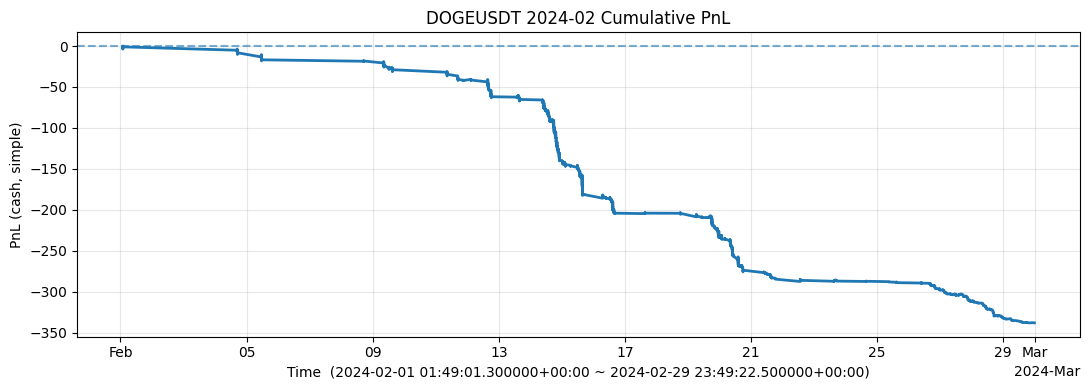

In [ ]:
# ========================= #한달 테스트
# CELL 2
# Backtest runner
# =========================

import pandas as pd

from hft_backtest_engine.feature_store import FeatureStore
from hft_backtest_engine.execution import ExecutionEngine
from hft_backtest_engine.backtest_engine import BacktestEngine
from hft_backtest_engine.strategy_base import Strategy, StrategyConfig
from hft_backtest_engine.metrics import compute_metrics, plot_cum_pnl

# =====================
# USER CONTROL ZONE
# =====================
INITIAL_CAPITAL = 100.0

# 👉 tick 기반 목표 (네가 조절)
TARGET_TICK_MULT  = 20.0
PARTIAL_TICK_MULT = 15.0

# 비용 가정 (bp)
FEE_BP_MARKET = 5.0
FEE_BP_LIMIT  = 2.0
SLIPPAGE_BP   = 1.0
SAFETY_MULT   = 1.2

# VPIN gate
VPIN_GATE_THRESHOLD = 0.7

# =====================
# FALLBACK (안전장치)
# =====================
if median_tick_bp is None or median_tick_bp <= 0:
    median_tick_bp = 1.0   # DOGE용 보수적 fallback

if mean_vpin_bucket is None or mean_vpin_bucket <= 0:
    mean_vpin_bucket = 200_000.0

# =====================
# TARGET / PARTIAL 계산
# =====================
cost_floor_bp = (FEE_BP_MARKET + FEE_BP_LIMIT + SLIPPAGE_BP) * SAFETY_MULT

TARGET_BP  = max(median_tick_bp * TARGET_TICK_MULT, cost_floor_bp)
PARTIAL_BP = max(median_tick_bp * PARTIAL_TICK_MULT, 0.5 * TARGET_BP)

print("=== CONFIG ===")
print(f"TARGET_BP  : {TARGET_BP:.2f} bp")
print(f"PARTIAL_BP : {PARTIAL_BP:.2f} bp")
print(f"VPIN bucket: {mean_vpin_bucket:,.0f}")

# =====================
# STRATEGY CONFIG
# =====================
config = StrategyConfig()
config.base_target_bp = TARGET_BP
config.partial_take_bp = PARTIAL_BP
config.vpin_gate_threshold = VPIN_GATE_THRESHOLD
config.max_holding_seconds = 4 * 60
config.max_leverage_notional = 1.0

feature_store = FeatureStore(
    symbol=SYMBOL,
    signal_interval_seconds=5 * 60,
    vpin_bucket_volume=mean_vpin_bucket,
    vpin_gate_threshold=config.vpin_gate_threshold,
)

strategy = Strategy(
    symbol=SYMBOL,
    feature_store=feature_store,
    config=config,
    initial_capital=INITIAL_CAPITAL,
    signal_interval_seconds=5 * 60,
)

execution = ExecutionEngine(
    latency_ms=5,
    slippage_bp=SLIPPAGE_BP,
    fee_bp_market=FEE_BP_MARKET,
    fee_bp_limit=FEE_BP_LIMIT,
    fill_price_mode="limit",
)

engine = BacktestEngine(
    loader=loader,          # CELL 1에서 만든 loader 그대로
    strategy=strategy,
    execution=execution,
    feature_store=feature_store,
    initial_capital=INITIAL_CAPITAL,
    verbose=False,
)

# =====================
# RUN MONTH
# =====================
fills = []
closed = []

for day in iter_days(DATE_START, DATE_END):
    try:
        engine.run_day(SYMBOL, day)
        fills.extend(engine.fills)
        closed.extend(engine.closed_trades)
    except FileNotFoundError:
        pass

fills_df = pd.DataFrame(fills)
closed_df = pd.DataFrame(closed)

print(f"[RESULT] fills={len(fills_df)} closed={len(closed_df)}")

# =====================
# METRICS + CUM PNL
# =====================
if closed_df.empty:
    print("❌ closed trades 없음")
else:
    equity_curve = (
        closed_df
        .sort_values("exit_ts")
        .assign(
            equity=lambda x: INITIAL_CAPITAL + x["net_pnl"].cumsum(),
            cash=lambda x: INITIAL_CAPITAL + x["net_pnl"].cumsum(),
            n_positions=0,
        )
        .loc[:, ["exit_ts", "equity", "cash", "n_positions"]]
        .rename(columns={"exit_ts": "ts"})
        .reset_index(drop=True)
    )

    metrics = compute_metrics(
        equity_curve=equity_curve,
        fills=fills_df if not fills_df.empty else None,
        initial_capital=INITIAL_CAPITAL,
    )

    print("\n=== METRICS ===")
    for k, v in metrics.items():
        print(f"{k:>25}: {v}")

    plot_cum_pnl(
        equity_curve,
        initial_capital=INITIAL_CAPITAL,
        title=f"{SYMBOL} 2024-02 Cumulative PnL",
    )


In [ ]:
import pandas as pd

from hft_backtest_engine.feature_store import FeatureStore
from hft_backtest_engine.execution import ExecutionEngine
from hft_backtest_engine.backtest_engine import BacktestEngine
from hft_backtest_engine.strategy_base import Strategy, StrategyConfig
from hft_backtest_engine.metrics import compute_metrics, plot_cum_pnl

# =====================
# USER CONTROL ZONE
# =====================
INITIAL_CAPITAL = 100.0

# 👉 tick 기반 목표 (네가 조절)
TARGET_TICK_MULT  = 8.0
PARTIAL_TICK_MULT = 5.0

# 비용 가정 (bp)
FEE_BP_MARKET = 2.0
FEE_BP_LIMIT  = 2.0
SLIPPAGE_BP   = 1.0
SAFETY_MULT   = 1.2

# VPIN gate
VPIN_GATE_THRESHOLD = 0.7

# =====================
# FALLBACK (안전장치)
# =====================
if median_tick_bp is None or median_tick_bp <= 0:
    median_tick_bp = 1.0   # DOGE용 보수적 fallback

if mean_vpin_bucket is None or mean_vpin_bucket <= 0:
    mean_vpin_bucket = 200_000.0

# =====================
# TARGET / PARTIAL 계산
# =====================
cost_floor_bp = (FEE_BP_MARKET + FEE_BP_LIMIT + SLIPPAGE_BP) * SAFETY_MULT

TARGET_BP  = max(median_tick_bp * TARGET_TICK_MULT, cost_floor_bp)
PARTIAL_BP = max(median_tick_bp * PARTIAL_TICK_MULT, 0.5 * TARGET_BP)

print("=== CONFIG ===")
print(f"TARGET_BP  : {TARGET_BP:.2f} bp")
print(f"PARTIAL_BP : {PARTIAL_BP:.2f} bp")
print(f"VPIN bucket: {mean_vpin_bucket:,.0f}")

# =====================
# STRATEGY CONFIG
# =====================
config = StrategyConfig()
config.base_target_bp = TARGET_BP
config.partial_take_bp = PARTIAL_BP
config.vpin_gate_threshold = VPIN_GATE_THRESHOLD
config.max_holding_seconds = 4 * 60
config.max_leverage_notional = 1.0

feature_store = FeatureStore(
    symbol=SYMBOL,
    signal_interval_seconds=5 * 60,
    vpin_bucket_volume=mean_vpin_bucket,
    vpin_gate_threshold=config.vpin_gate_threshold,
)

strategy = Strategy(
    symbol=SYMBOL,
    feature_store=feature_store,
    config=config,
    initial_capital=INITIAL_CAPITAL,
    signal_interval_seconds=5 * 60,
)

execution = ExecutionEngine(
    latency_ms=5,
    slippage_bp=SLIPPAGE_BP,
    fee_bp_market=FEE_BP_MARKET,
    fee_bp_limit=FEE_BP_LIMIT,
    fill_price_mode="limit",
)

engine = BacktestEngine(
    loader=loader,          # CELL 1에서 만든 loader 그대로
    strategy=strategy,
    execution=execution,
    feature_store=feature_store,
    initial_capital=INITIAL_CAPITAL,
    verbose=False,
)

SYMBOL = "XRPUSDT"
DAY = "2024-02-15"   # 👈 테스트할 하루 (YYYY-MM-DD)

engine.run_day(SYMBOL, DAY)

fills_df = pd.DataFrame(engine.fills)
closed_df = pd.DataFrame(engine.closed_trades)

print(f"[RESULT] DAY={DAY}")
print(f"fills  : {len(fills_df)}")
print(f"closed : {len(closed_df)}")

# =========================
# METRICS + PNL
# =========================
if closed_df.empty:
    print("❌ closed trades 없음")
else:
    equity_curve = (
        closed_df
        .sort_values("exit_ts")
        .assign(
            equity=lambda x: INITIAL_CAPITAL + x["net_pnl"].cumsum(),
            cash=lambda x: INITIAL_CAPITAL + x["net_pnl"].cumsum(),
            n_positions=0,
        )
        .loc[:, ["exit_ts", "equity", "cash", "n_positions"]]
        .rename(columns={"exit_ts": "ts"})
        .reset_index(drop=True)
    )

    from hft_backtest_engine.metrics import compute_metrics, plot_cum_pnl

    metrics = compute_metrics(
        equity_curve=equity_curve,
        fills=fills_df if not fills_df.empty else None,
        initial_capital=INITIAL_CAPITAL,
    )

    print("\n=== METRICS (ONE DAY) ===")
    for k, v in metrics.items():
        print(f"{k:>25}: {v}")

    plot_cum_pnl(
        equity_curve,
        initial_capital=INITIAL_CAPITAL,
        title=f"{SYMBOL} {DAY} Cumulative PnL",
    )

=== CONFIG ===
TARGET_BP  : 14.90 bp
PARTIAL_BP : 9.31 bp
VPIN bucket: 1,336,758
